# <font color='Orange'> ML project </font>

### Introduction:

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.

### Objective:

The goal of this notebook is various predictive algorms are available as far as we can predict which goals in order to see failure in the future.

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# preprocessing and resampling
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# ML model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

np.warnings.filterwarnings('ignore')

# Import and data cleansing

In [9]:
df = pd.read_csv ('/content/drive/MyDrive/Kaggle_code/Bankruptcy/bankruptcy.csv')
df.rename(columns = {'Bankrupt?':'y'}, inplace = True)
# rename columns
lista_new_col = []
for col in df.columns:
  col = re.sub(' ', '_', col)
  col = re.sub('-', '_', col)
  lista_new_col.append(col)
df.columns = lista_new_col

print ( 'Shape of dataset:', df.shape )
print ( '*' * 50 )
df.head()

Shape of dataset: (6819, 96)
**************************************************


,y,_ROA(C)_before_interest_and_depreciation_before_interest,_ROA(A)_before_interest_and_%_after_tax,_ROA(B)_before_interest_and_depreciation_after_tax,_Operating_Gross_Margin,_Realized_Sales_Gross_Margin,_Operating_Profit_Rate,_Pre_tax_net_Interest_Rate,_After_tax_net_Interest_Rate,_Non_industry_income_and_expenditure/revenue,_Continuous_interest_rate_(after_tax),_Operating_Expense_Rate,_Research_and_development_expense_rate,_Cash_flow_rate,_Interest_bearing_debt_interest_rate,_Tax_rate_(A),_Net_Value_Per_Share_(B),_Net_Value_Per_Share_(A),_Net_Value_Per_Share_(C),_Persistent_EPS_in_the_Last_Four_Seasons,_Cash_Flow_Per_Share,_Revenue_Per_Share_(Yuan_¥),_Operating_Profit_Per_Share_(Yuan_¥),_Per_Share_Net_profit_before_tax_(Yuan_¥),_Realized_Sales_Gross_Profit_Growth_Rate,_Operating_Profit_Growth_Rate,_After_tax_Net_Profit_Growth_Rate,_Regular_Net_Profit_Growth_Rate,_Continuous_Net_Profit_Growth_Rate,_Total_Asset_Growth_Rate,_Net_Value_Growth_Rate,_Total_Asset_Return_Growth_Rate_Ratio,_Cash_Reinvestment_%,_Current_Ratio,_Quick_Ratio,_Interest_Expense_Ratio,_Total_debt/Total_net_worth,_Debt_ratio_%,_Net_worth/Assets,_Long_term_fund_suitability_ratio_(A),...,_Current_Assets/Total_Assets,_Cash/Total_Assets,_Quick_Assets/Current_Liability,_Cash/Current_Liability,_Current_Liability_to_Assets,_Operating_Funds_to_Liability,_Inventory/Working_Capital,_Inventory/Current_Liability,_Current_Liabilities/Liability,_Working_Capital/Equity,_Current_Liabilities/Equity,_Long_term_Liability_to_Current_Assets,_Retained_Earnings_to_Total_Assets,_Total_income/Total_expense,_Total_expense/Assets,_Current_Asset_Turnover_Rate,_Quick_Asset_Turnover_Rate,_Working_capitcal_Turnover_Rate,_Cash_Turnover_Rate,_Cash_Flow_to_Sales,_Fixed_Assets_to_Assets,_Current_Liability_to_Liability,_Current_Liability_to_Equity,_Equity_to_Long_term_Liability,_Cash_Flow_to_Total_Assets,_Cash_Flow_to_Liability,_CFO_to_Assets,_Cash_Flow_to_Equity,_Current_Liability_to_Current_Assets,_Liability_Assets_Flag,_Net_Income_to_Total_Assets,_Total_assets_to_GNP_price,_No_credit_Interval,_Gross_Profit_to_Sales,_Net_Income_to_Stockholder's_Equity,_Liability_to_Equity,_Degree_of_Financial_Leverage_(DFL),_Interest_Coverage_Ratio_(Interest_expense_to_EBIT),_Net_Income_Flag,_Equity_to_Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.3

In [ ]:
df.isna().sum()

There is no missing data in the dataset.

# Data analysis & visualization

In [ ]:
df.info()

The dataset is composed of a combination of 6819 observations per each of our 96 features.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
y,6819.0,0.032263,0.176710,0.0,0.000000,0.000000,0.000000,1.0
_ROA(C)_before_interest_and_depreciation_before_interest,6819.0,0.505180,0.060686,0.0,0.476527,0.502706,0.535563,1.0
_ROA(A)_before_interest_and_%_after_tax,6819.0,0.558625,0.065620,0.0,0.535543,0.559802,0.589157,1.0
_ROA(B)_before_interest_and_depreciation_after_tax,6819.0,0.553589,0.061595,0.0,0.527277,0.552278,0.584105,1.0
_Operating_Gross_Margin,6819.0,0.607948,0.016934,0.0,0.600445,0.605997,0.613914,1.0
...,...,...,...,...,...,...,...,...
_Liability_to_Equity,6819.0,0.280365,0.014463,0.0,0.276944,0.278778,0.281449,1.0
_Degree_of_Financial_Leverage_(DFL),6819.0,0.027541,0.015668,0.0,0.026791,0.026808,0.026913,1.0
_Interest_Coverage_Ratio_(Interest_expense_to_EBIT),6819.0,0.565358,0.013214,0.0,0.565158,0.565252,0.565725,1.0
_Net_Income_Flag,6819.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0


In [10]:
print(df.y.value_counts())
print('-'* 30)
print('Financially stable: ', round(df.y.value_counts()[0]/len(df) * 100, 2), '% of the dataset')
print('Financially unstable: ', round(df.y.value_counts()[1]/len(df) * 100, 2), '% of the dataset')

0    6599
1     220
Name: y, dtype: int64
------------------------------
Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset


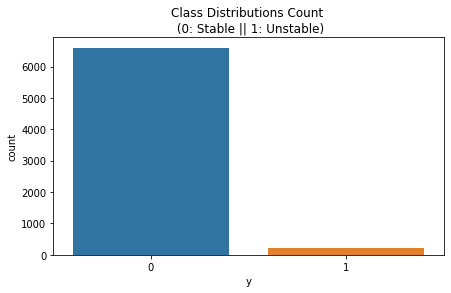

In [11]:
plt.figure(figsize = (7,4))
sns.countplot(df.y)
plt.title('Class Distributions Count \n (0: Stable || 1: Unstable)', fontsize=12)
plt.show()

The classes are heavily skewed we need to solve this issue later, with algorithm SMOTE (**S**ynthetic **M**inority **O**versampling **TE**chnique).

Class 1 represents 96.77% of the dataset, while class 2 only 3.23%.

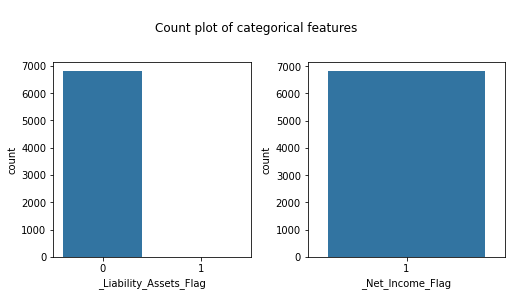

In [12]:
cat_cols = df.select_dtypes(include=['object','category','int64']).columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,4), constrained_layout=True)
ax=ax.flatten()
fig.suptitle('\nCount plot of categorical features\n', size=12)
for x,i in enumerate(cat_cols[1:]):
    sns.countplot(x=df[i], ax=ax[x])

In [13]:
print ( 'The column "Net income flag" have just value:', df._Net_Income_Flag.unique() )
df.drop ('_Net_Income_Flag', axis=1, inplace=True )

The column "Net income flag" have just value: [1]


The feature 'Net income flag' always takes the value 1 for all observations, so it can be removed from the model.

In [ ]:
# Looking at the histograms of numerical data
df.hist(figsize = (35,30), bins = 50 )
plt.show()

# Re-sampling train_set (SMOTE algorithm)

In [15]:
# SMOTE
X, y = df.iloc [ :, 1: ].values , df.iloc [:, 0].values
X_train, X_test, y_train, y_test = train_test_split ( X, y,
                                                     test_size = 0.3,
                                                     random_state = 1,
                                                     stratify = y)
smt = SMOTE ()
X_train_sm, y_train_sm = smt.fit_resample (X_train, y_train)

print ('# class in y_train:', np.bincount (y_train_sm) )

# class in y_train: [4619 4619]


After the application of SMOTE the classes are rebalanced and both classes of target variable have the same number of 4619 observations.

Let's now apply the machine learning models with the training dataset resampled and balanced according to the target variable: therefore each class will have the same weight and will not be treated differently than the others.

NB: I would like to clarify that the balancing of the classes is done in the training set, therefore in the training phase, and that a correct prediction is right to do it on unnoticed data, precisely the test set.

# Models

We will see the performances on the SMOTE oversampled data (we call *X_train_sm* and y_train_sm). For this I decided to use a few different models classifier:

- Logistic Regression
- Decision Tree Classifier
- K-Nearest Neighbors
- Support Vector Machine
- Random Forest Classifier



---




- **Train set:**  X_train_std, y_train_sm

- **Test set:**  X_test_std, y_test

## Logistic Regression

In [19]:
pipeline_lr = make_pipeline ( StandardScaler(),
                          LogisticRegression ( penalty='none', C=1.0, solver='lbfgs', random_state=24 )
                          )
pipeline_lr.fit ( X_train_sm, y_train_sm )
scores = cross_val_score ( estimator=pipeline_lr,
                          X = X_train_sm,
                          y = y_train_sm,
                          cv=5,
                          n_jobs = 2)
y_pred_lr = pipeline_lr.predict (X_test)
print ( 'Accuracy train: %.3f' %pipeline_lr.score (X_train_sm, y_train_sm) )
print ( 'Accuracy cross-validation: %.3f' %scores.mean() )
print ( 'Accuracy test: %.3f' %pipeline_lr.score (X_test, y_test) )

Accuracy train: 0.913
Accuracy cross-validation: 0.909
Accuracy test: 0.888


In [20]:
# learning curve
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipeline_lr,
                               X=X_train_sm,
                               y=y_train_sm,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=2)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

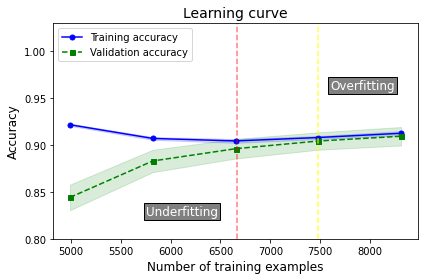

In [23]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.xlabel('Number of training examples', size=12)
plt.ylabel('Accuracy', size=12)
plt.legend(loc='upper left')
plt.ylim([0.8, 1.03])
plt.axvline(x=6670, color = 'red', linestyle = '--', alpha = 0.5)
plt.axvline(x=7480, color = 'yellow', linestyle = '--', alpha = 0.7)
plt.text(5750, 0.825, 'Underfitting', fontsize=12, color='white', bbox ={'facecolor':'grey', 'pad':2} )
plt.text(7600, 0.96, 'Overfitting', fontsize=12, color='white',bbox ={'facecolor':'grey', 'pad':2} )
plt.title ('Learning curve', size=14)
plt.tight_layout()
plt.grid(b=False)
plt.show()

As can be seen from the graph, the model performs well on both training and validation data if at least 6670 examples are submitted to it during training (as indicated by the dashed red vertical line).

Also note, as indicated by the yellow dashed vertical line, that the distance between accuracy in training and accuracy in validation widens with a dataset of more than 7480 examples: an indicator of an increasing level of overfitting.

## Decision Tree Classifier

In [28]:
pipeline_tree = make_pipeline ( StandardScaler(),
                          DecisionTreeClassifier ( min_samples_split=4, random_state=42 )
                          )
pipeline_tree.fit ( X_train_sm, y_train_sm )
scores = cross_val_score ( estimator=pipeline_tree,
                          X = X_train_sm,
                          y = y_train_sm,
                          cv=5,
                          n_jobs = 2)
y_pred_tree = pipeline_tree.predict (X_test)
print ( 'Accuracy train: %.3f' %pipeline_tree.score (X_train_sm, y_train_sm) )
print ( 'Accuracy cross-validation: %.3f' %scores.mean() )
print ( 'Accuracy test: %.3f' %pipeline_tree.score (X_test, y_test) )

Accuracy train: 0.999
Accuracy cross-validation: 0.953
Accuracy test: 0.934


In [29]:
# validation curve
param_range = [1,2,3,4,5,6,7,8,9,10]

train_scores, test_scores = validation_curve(
                estimator=pipeline_tree, 
                X=X_train, 
                y=y_train, 
                param_name='decisiontreeclassifier__min_samples_split', 
                param_range=param_range,
                cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

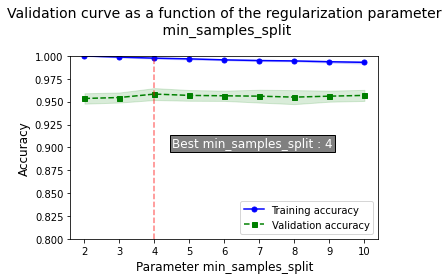

In [30]:
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid(b=False)
plt.legend(loc='lower right')
plt.xlabel('Parameter min_samples_split', size=12)
plt.ylabel('Accuracy', size=12)
plt.title ('Validation curve as a function of the regularization parameter\n min_samples_split\n', size=14)
plt.ylim([0.8, 1.0])
plt.axvline(x=4, color = 'red', linestyle = '--', alpha = 0.5)
plt.text(4.5, 0.9, 'Best min_samples_split : 4', fontsize=12, color='white',bbox ={'facecolor':'grey', 'pad':2} )
plt.tight_layout()
plt.show()

## K-Nearest Neighbors

In [31]:
pipeline_knn = make_pipeline ( StandardScaler(),
                          KNeighborsClassifier (n_neighbors=5, weights='distance', p=2 )
                          )
pipeline_knn.fit ( X_train_sm, y_train_sm )
scores = cross_val_score ( estimator=pipeline_knn,
                          X = X_train_sm,
                          y = y_train_sm,
                          cv=5,
                          n_jobs = 2)
y_pred_knn = pipeline_knn.predict (X_test)
print ( 'Accuracy train: %.3f' %pipeline_knn.score (X_train_sm, y_train_sm) )
print ( 'Accuracy cross-validation: %.3f' %scores.mean() )
print ( 'Accuracy test: %.3f' %pipeline_knn.score (X_test, y_test) )

Accuracy train: 1.000
Accuracy cross-validation: 0.942
Accuracy test: 0.905


## Support vector machine

In [32]:
pipeline_svm = make_pipeline ( StandardScaler(),
                          SVC (random_state=1, C=1.0, kernel='rbf', gamma='scale')
                          )
pipeline_svm.fit ( X_train_sm, y_train_sm )
scores = cross_val_score ( estimator=pipeline_svm,
                          X = X_train_sm,
                          y = y_train_sm,
                          cv=5,
                          n_jobs = 2)
y_pred_svm = pipeline_svm.predict (X_test)
print ( 'Accuracy train: %.3f' %pipeline_svm.score (X_train_sm, y_train_sm) )
print ( 'Accuracy cross-validation: %.3f' %scores.mean() )
print ( 'Accuracy test: %.3f' %pipeline_svm.score (X_test, y_test) )

Accuracy train: 0.966
Accuracy cross-validation: 0.959
Accuracy test: 0.926


## Ensemble learning - Random Forest

In [33]:
pipeline_rfc = make_pipeline ( StandardScaler(),
                          RandomForestClassifier(criterion='entropy', random_state=1)
                          )
pipeline_rfc.fit ( X_train_sm, y_train_sm )
scores = cross_val_score ( estimator=pipeline_rfc,
                          X = X_train_sm,
                          y = y_train_sm,
                          cv=5,
                          n_jobs = 2)
y_pred_rfc = pipeline_rfc.predict (X_test)
print ( 'Accuracy train: %.3f' %pipeline_rfc.score (X_train_sm, y_train_sm) )
print ( 'Accuracy cross-validation: %.3f' %scores.mean() )
print ( 'Accuracy test: %.3f' %pipeline_rfc.score (X_test, y_test) )

Accuracy train: 1.000
Accuracy cross-validation: 0.979
Accuracy test: 0.956


**RESUME:** Trained Classifiers Performance Report on Test Set:

In [34]:
pred_list = [y_pred_lr, y_pred_tree, y_pred_knn, y_pred_rfc, y_pred_svm ]
name_clf = [ 'Logistic Regression', 'Decision Tree', 'K-NN', 'Random Forest', 'Support vector machine' ]
for name, y_pred in zip(name_clf, pred_list ):
  print (f'---> {name}')
  print (f'Accuracy: %0.3f' %accuracy_score (y_test, y_pred))
  print (f'Recall: %0.3f' %recall_score (y_test, y_pred))
  print (f'F1 score: %0.3f' %f1_score (y_test, y_pred))
  print ('')

---> Logistic Regression
Accuracy: 0.888
Recall: 0.758
F1 score: 0.303

---> Decision Tree
Accuracy: 0.934
Recall: 0.348
F1 score: 0.253

---> K-NN
Accuracy: 0.905
Recall: 0.545
F1 score: 0.271

---> Random Forest
Accuracy: 0.956
Recall: 0.485
F1 score: 0.413

---> Support vector machine
Accuracy: 0.926
Recall: 0.515
F1 score: 0.309



The results show that the model with the greatest accuracy is the Random Forest. However, in this case we are more concerned with minimizing the likelihood of not detecting banks that really are close to failure. This is why it is best to look at the results of *Recall*, for which it seems that the best decision is Logistic Regression.

Now let's optimize its hyperparameters with a grid search.

# Hyperparameter optimization

In [35]:
# classification report before optimizing hyperparameters
label = ['Stable', 'Unstable']
print(classification_report(y_test, y_pred_lr, target_names=label))

              precision    recall  f1-score   support

      Stable       0.99      0.89      0.94      1980
    Unstable       0.19      0.76      0.30        66

    accuracy                           0.89      2046
   macro avg       0.59      0.82      0.62      2046
weighted avg       0.97      0.89      0.92      2046



In [36]:
# pipeline
pipeline_lr = make_pipeline ( StandardScaler(),
                          LogisticRegression ()
                          )

# range valori dei oparametri C
param_range = [ 0.001, 0.01, 0.1, 1.0 ]
# creo griglia parametri
grid_param = [ { 'logisticregression__C' : param_range,
               'logisticregression__penalty' : ['l2', 'l1', 'none'],
               'logisticregression__solver' : ['lbfgs', 'saga'] } ]
gs = GridSearchCV ( estimator = pipeline_lr,
                   param_grid = grid_param,
                   scoring = 'recall',
                   cv = 5,
                   refit = True,
                   n_jobs = 2
                   )

gs = gs.fit ( X_train_sm, y_train_sm )

print ( 'Best score: %.3f' %gs.best_score_ )

print ( 'Best hyperparameter:', gs.best_params_ )

y_pred_gs = gs.predict (X_test)

Best score: 0.922
Best hyperparameter: {'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}


In [37]:
# classification report before optimizing hyperparameters
label = ['Bank stable', 'Bank unstable']
print(classification_report(y_test, y_pred_gs, target_names=label))

               precision    recall  f1-score   support

  Bank stable       0.99      0.90      0.94      1980
Bank unstable       0.20      0.77      0.32        66

     accuracy                           0.89      2046
    macro avg       0.60      0.83      0.63      2046
 weighted avg       0.97      0.89      0.92      2046



Following the optimization of the hyperparameters, an improvement in the Recall is observed, which passes from 0.76 to 0.77.

Now, looking at the confusion matrix:

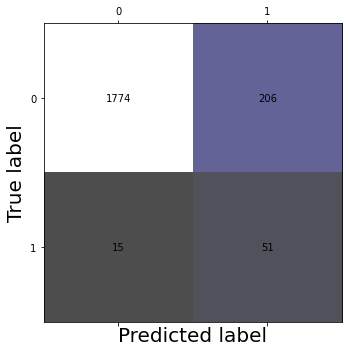

In [38]:
conf_matrix = confusion_matrix (  y_test, y_pred_gs )

# plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap='CMRmap', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')
plt.xlabel('Predicted label', size = 20)
plt.ylabel('True label', size = 20)
plt.tight_layout()
plt.show()

From the confusion matrix it is concluded that:

- the optimized model commits 221 classification errors

- deeming it more serious to make the mistake of classifying a company as stable in an unstable reality, our classifier does an excellent job because he makes only 15 mistakes (of 221
totals) of this type on the entire test dataset (consisting of 2046 examples).